In [2]:
pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Note: you may need to restart the kernel to use updated packages.


In [3]:
# the bare minimum
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import plugins
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.colors import ListedColormap
import numpy as np

# more advanced
from lonboard._map import Map
from lonboard._layer import PolygonLayer  # for mapping in 3D
from lonboard.colormap import (
    apply_categorical_cmap,
    apply_continuous_cmap,
)  # for assigning colors
from palettable.colorbrewer.sequential import PuRd_9  # for color palettes
from matplotlib.colors import LogNorm  # for logarithmic normalization
import pygwalker as pyg  # for creating interactive data visualizations

In [5]:
# I'm going to load and look at the Transportation Structures in NYC Data Set
transport = gpd.read_file(
    "/Users/alinetheo/Documents/Columbia/Summer 2025/Mapping Systems/Data Sets/NYC Planimetric Database_ Transportation Structures_20250711/geo_export_26a8cb53-5eaf-4f1b-b83c-2b268fc092a6.shp"
)

In [6]:
transport.head()

,source_id,sub_code,feat_code,name,status,shape_leng,shape_area,geometry
0,1.323000e+10,230000.0,2300.0,NO NAME,Updated,32349.778891,1.269776e+06,"POLYGON ((-73.88735 40.82205, -73.88738 40.822..."
1,1.423300e+10,233000.0,2330.0,NO NAME,Unchanged,106.016474,2.185770e+02,"POLYGON ((-73.92427 40.82721, -73.92428 40.827..."
2,0.000000e+00,230000.0,2300.0,None,New,708.530999,8.596574e+03,"POLYGON ((-73.90866 40.72745, -73.9085 40.7273..."
3,1.323300e+10,233000.0,2330.0,NO NAME,Unchanged,539.036395,2.100705e+03,"POLYGON ((-73.9387 40.78659, -73.93896 40.7863..."
4,1.223100e+10,231000.0,2310.0,NO NAME,Unchanged,82.542414,3.307481e+01,"POLYGON ((-73.97669 40.75432, -73.9767 40.7543..."


In [7]:
transport.columns

Index(['source_id', 'sub_code', 'feat_code', 'name', 'status', 'shape_leng',
       'shape_area', 'geometry'],
      dtype='object')

In [8]:
transport.status.value_counts()

status
Unchanged    2086
Updated        96
New            65
Name: count, dtype: int64

In [9]:
# I want to plot the number of structures by the status of the structure
feat_counts = transport["feat_code"].value_counts()
feat_counts

feat_code
2300.0    1164
2330.0     376
2320.0     359
2310.0     335
2340.0       8
2350.0       5
Name: count, dtype: int64

In [10]:
status_counts = transport["status"].value_counts()
status_counts

status
Unchanged    2086
Updated        96
New            65
Name: count, dtype: int64

In [11]:
# Define colors for different status values
status_colors = {
    "Updated": "#f0bd04",
    "Unchanged": "#ff0000",
    "New": "#219F21",  # Green
    "Unknown": "#95a5a6",  # Gray
}

(array([0, 1, 2]),
 [Text(0, 0, 'Unchanged'), Text(1, 0, 'Updated'), Text(2, 0, 'New')])

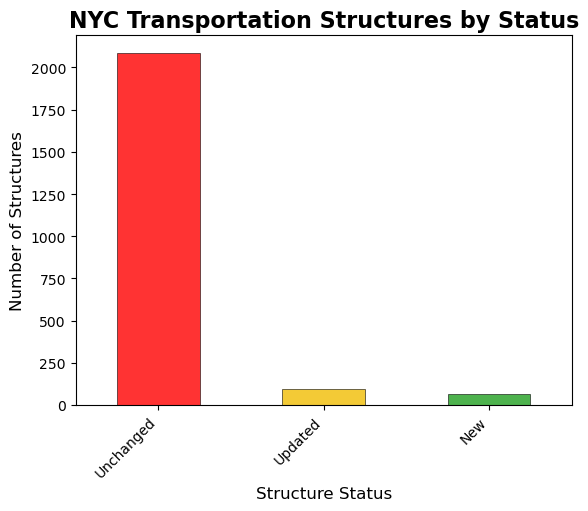

In [12]:
# Get colors for each status in the order they appear
bar_colors = [status_colors.get(status, "#34495e") for status in status_counts.index]

# Create the bar chart
ax = status_counts.plot(
    kind="bar", color=bar_colors, alpha=0.8, edgecolor="black", linewidth=0.5
)

# Customize the chart
plt.title("NYC Transportation Structures by Status", fontsize=16, fontweight="bold")
plt.xlabel("Structure Status", fontsize=12)
plt.ylabel("Number of Structures", fontsize=12)
plt.xticks(rotation=45, ha="right")

In [13]:
# That's a lot of unchanged structures!

In [14]:
# Now I want to focus on the status of the transportation structures to visualize a map
transport_status_codes = {
    "01": "Unchanged",
    "02": "Updated",
    "03": "New",
}

In [15]:
transport["status"] = transport.status.map(transport_status_codes)

Box(children=(HTML(value='\n<div id="ifr-pyg-00063ba191599d8dzaoYGUBJD8gjvkCf" style="height: auto">\n    <hea…

Text(0.5, 1.0, 'NYC Transportation Structures Map')

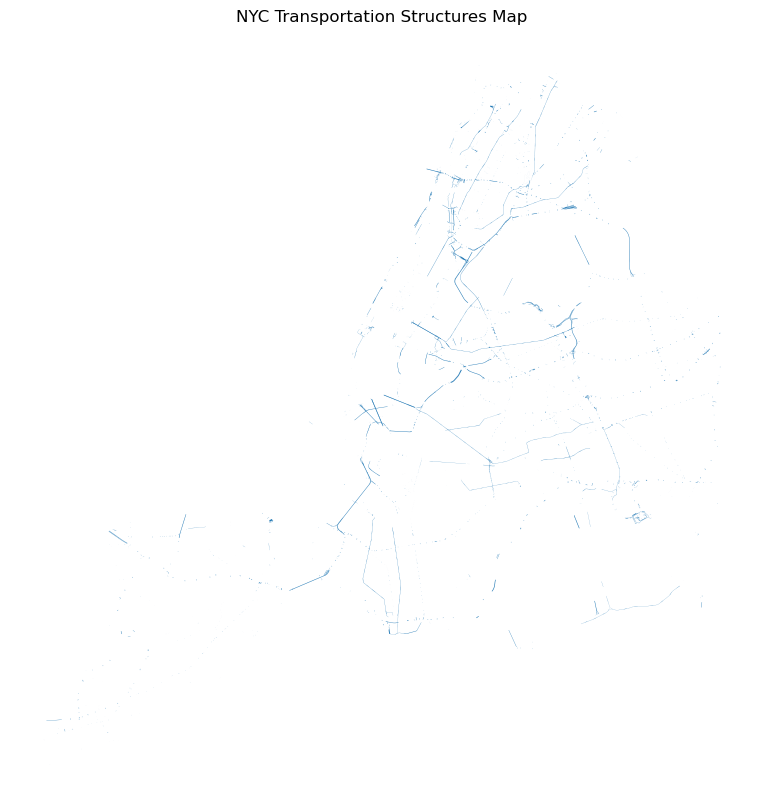

In [16]:
transport_non_spatial = transport.drop(columns=["geometry"])

# Invoke pygwalker, begin exploring the data interactively
pyg.walk(transport_non_spatial)

transport.plot(figsize=(10, 10)).set_axis_off()
plt.title("NYC Transportation Structures Map")

In [17]:
transport.fillna({"status": "Unknown"}, inplace=True)

In [18]:
transport.status.unique()

array(['Unknown'], dtype=object)

In [19]:
cmap = {
    "Updated": "#f0bd04",
    "Unchanged": "#ff0000",
    "New": "#219F21",
}

In [20]:
transport["color"].unique()

KeyError: 'color'

In [21]:
transport["color"] = transport["status"].map(cmap)

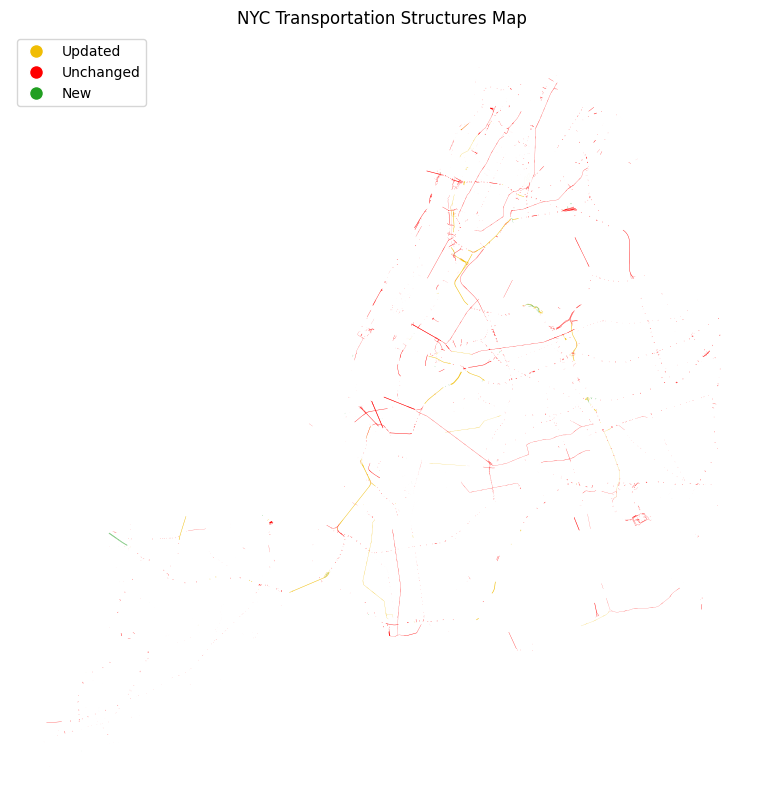

In [113]:
ax = transport.plot(
    color=transport["color"],
    figsize=(10, 10),
    legend=True,
).set_axis_off()
plt.title("NYC Transportation Structures Map")


# populate legend items based on dict from above
legend_colors = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
labels = cmap.keys()
plt.legend(legend_colors, labels, loc="upper left")

In [22]:
# I want to overlay the transportation information on top of a map of NYC boundaries to give context

boundaries = gpd.read_file(
    "/Users/alinetheo/Documents/Columbia/Summer 2025/Mapping Systems/Data Sets/nybb_25b 2/nybb.shp"
)

In [23]:
print("Boundaries CRS:", boundaries.crs)
print("Transport CRS:", transport.crs)

Boundaries CRS: EPSG:2263
Transport CRS: EPSG:4326


In [24]:
boundaries = boundaries.to_crs(transport.crs)

In [25]:
print("Boundaries CRS:", boundaries.crs)
print("Transport CRS:", transport.crs)

Boundaries CRS: EPSG:4326
Transport CRS: EPSG:4326


ValueError: Invalid RGBA argument: nan

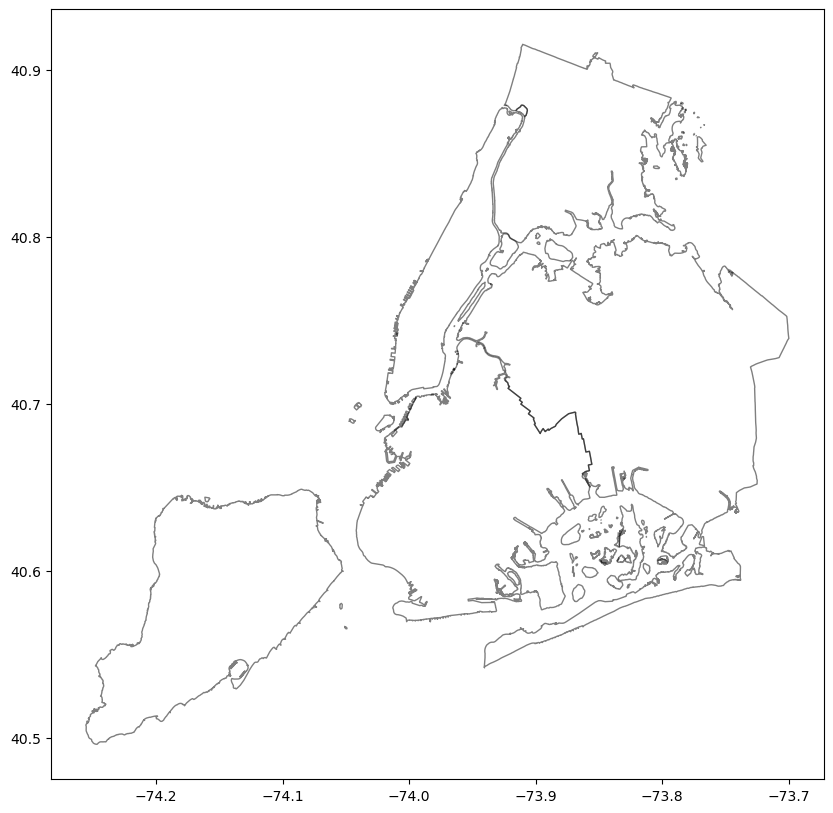

In [26]:
# Create a single figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Plot boundaries first (as background) - just outlines, no fill
boundaries.boundary.plot(ax=ax, color="black", linewidth=1, alpha=0.5)

# Plot transportation structures on top
transport.plot(ax=ax, color=transport["color"], legend=False)

# populate legend items based on dict from above
legend_colors = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
labels = cmap.keys()
plt.legend(legend_colors, labels, loc="upper left")

In [61]:
# It seems like there is a lot of missing data! Especially in Manhattan which is surprising.
# The map shows that the transportation structures are mostly unchanged, which is what I expected

In [ ]:
# Now I'm going to load and look at the Future Floodplains 2050s in NYC data set and see how it compares to the transportation structures

In [28]:
rainfall = gpd.read_file("nyc-rainfall-data.csv")

In [29]:
rainfall.head()

,ate,year,month,total_rainfall_inches,days_with_rain,max_daily_rainfall,max_hourly_rainfall,notable_events,infrastructure_capacity_exceeded,storm_name
0,1999-01-01,1999,1,3.2,8,0.85,0.6,Normal winter precipitation,No,
1,1999-02-01,1999,2,2.1,6,0.45,0.4,Driest month typical,No,
2,1999-03-01,1999,3,4.1,10,1.2,0.8,Spring rains begin,No,
3,1999-04-01,1999,4,3.8,9,0.95,0.7,Normal spring,No,
4,1999-05-01,1999,5,4.5,11,1.4,0.9,Typical May,No,


In [30]:
rainfall.columns

Index(['ate', 'year', 'month', 'total_rainfall_inches', 'days_with_rain',
       'max_daily_rainfall', 'max_hourly_rainfall', 'notable_events',
       'infrastructure_capacity_exceeded', 'storm_name'],
      dtype='object')

In [31]:
# Checking to see if the dataset is empty
if rainfall.empty:
    print("Dataset is empty")
else:
    print("Dataset has data")

Dataset has data


In [ ]:
# Now I'm going to look at the Distribution of Flood Zones with a bar chart

zone_counts = rainfall["fld_zone"].value_counts()
zone_counts

fld_zone
AE    3729
VE    2823
AO      43
Name: count, dtype: int64

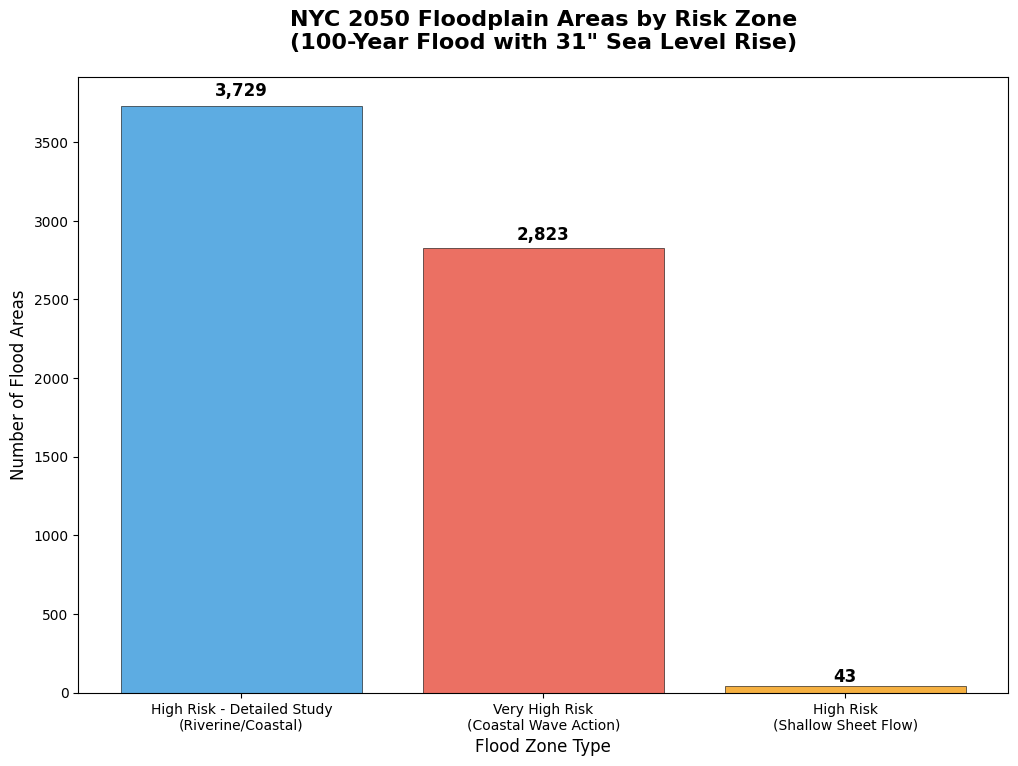

In [132]:
# Bar chart of flood zone types
plt.figure(figsize=(12, 8))  # Made it wider to accommodate longer labels

# Define colors for different flood zones
zone_colors = {
    "AE": "#3498db",  # Blue - high risk
    "VE": "#e74c3c",  # Red - very high risk
    "AO": "#f39c12",  # Orange - high risk shallow
}

# Get colors for each zone
bar_colors = [zone_colors.get(zone, "#95a5a6") for zone in zone_counts.index]

# Create bar chart
bars = plt.bar(
    range(len(zone_counts)),
    zone_counts.values,
    color=bar_colors,
    alpha=0.8,
    edgecolor="black",
    linewidth=0.5,
)

# Customize the chart
plt.title(
    'NYC 2050 Floodplain Areas by Risk Zone\n(100-Year Flood with 31" Sea Level Rise)',
    fontsize=16,
    fontweight="bold",
    pad=20,
)
plt.xlabel("Flood Zone Type", fontsize=12)
plt.ylabel("Number of Flood Areas", fontsize=12)

# Set x-axis labels with descriptions
descriptive_labels = [zone_labels.get(zone, zone) for zone in zone_counts.index]
plt.xticks(range(len(zone_counts)), descriptive_labels, rotation=0, ha="center")

# Add value labels on top of bars
for i, v in enumerate(zone_counts.values):
    plt.text(
        i,
        v + v * 0.01,
        f"{v:,}",
        ha="center",
        va="bottom",
        fontweight="bold",
        fontsize=12,
    )

Box(children=(HTML(value='\n<div id="ifr-pyg-000639adf2d1b262Vvq5o3J4DHsg1xKX" style="height: auto">\n    <hea…

Text(0.5, 1.0, 'NYC Floodplains 2050s')

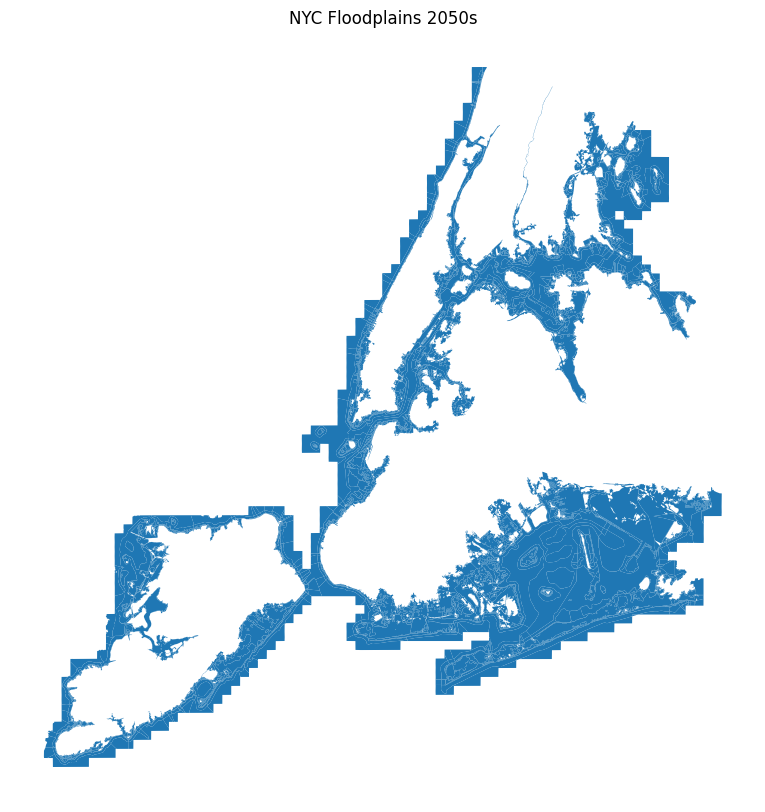

In [134]:
# Now I'm going to map the floodplain areas

# pygwalker doesn't suppert geospatial data directly, so we need to drop the geometry column.
# Be sure to keep a copy of the original data, we'll need it later!
flood_non_spatial = flood.drop(columns=["geometry"])

# Invoke pygwalker, begin exploring the data interactively
pyg.walk(flood_non_spatial)

flood.plot(figsize=(10, 10)).set_axis_off()
plt.title("NYC Floodplains 2050s")

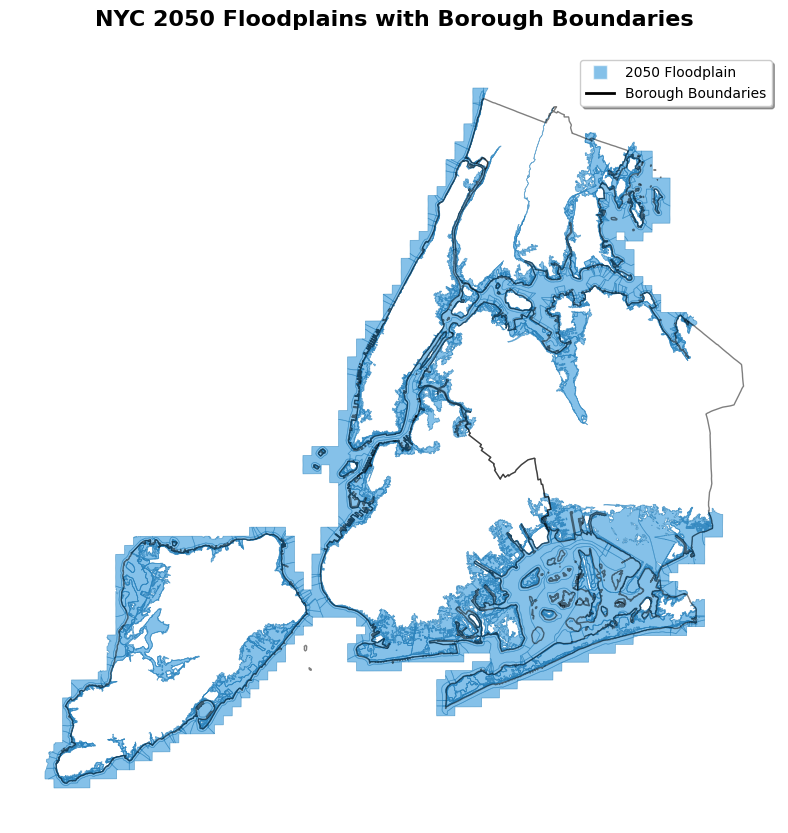

In [136]:
# overlaying on boundaries map

# Create a single figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Plot boundaries first (as background) - just outlines, no fill
boundaries.boundary.plot(ax=ax, color="black", linewidth=1, alpha=0.5)

# Plot floodplain areas on top with a single color
flood.plot(
    ax=ax, color="#3498db", alpha=0.6, edgecolor="#2980b9", linewidth=0.5, legend=False
)

# Set title and remove axes
ax.set_axis_off()
ax.set_title(
    "NYC 2050 Floodplains with Borough Boundaries",
    fontsize=16,
    fontweight="bold",
    pad=20,
)

# Add a simple legend for the floodplain
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="s",
        color="w",
        markerfacecolor="#3498db",
        markersize=10,
        alpha=0.6,
        label="2050 Floodplain",
    ),
    Line2D([0], [0], color="black", linewidth=2, label="Borough Boundaries"),
]
ax.legend(
    handles=legend_elements, loc="upper right", frameon=True, fancybox=True, shadow=True
)

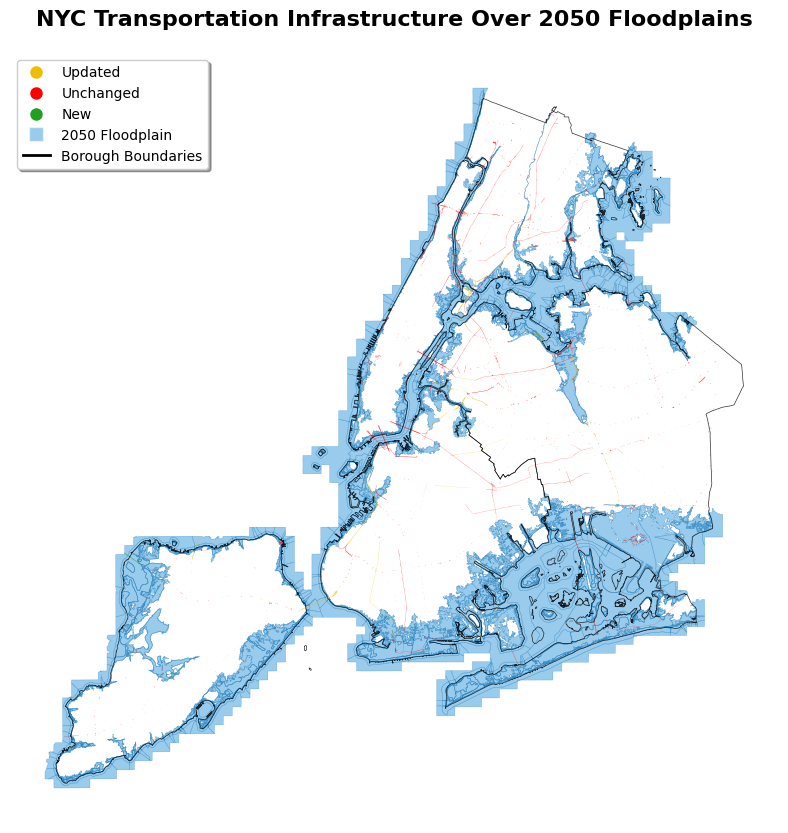

In [140]:
# Now I'm going to overlay the transportation structures map onto the floodplain map to see which areas are at risk

# Create a single figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Layer 1: Plot boundaries first (as background) - just outlines, no fill
boundaries.boundary.plot(ax=ax, color="black", linewidth=0.5, alpha=0.8)

# Layer 2: Plot flood areas (middle layer)
flood.plot(
    ax=ax, color="#3498db", alpha=0.5, edgecolor="#2980b9", linewidth=0.3, legend=False
)

# Layer 3: Plot transportation structures on top (foreground)
transport.plot(ax=ax, color=transport["color"], alpha=0.8, linewidth=5, legend=False)

# Set title and remove axes
ax.set_axis_off()
ax.set_title(
    "NYC Transportation Infrastructure Over 2050 Floodplains",
    fontsize=16,
    fontweight="bold",
    pad=20,
)

# Create combined legend
# Transportation legend items
transport_legend = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
transport_labels = list(cmap.keys())

# Flood and boundary legend items
flood_legend = [
    Line2D(
        [0],
        [0],
        marker="s",
        color="w",
        markerfacecolor="#3498db",
        markersize=10,
        alpha=0.5,
        label="2050 Floodplain",
    ),
    Line2D([0], [0], color="black", linewidth=2, label="Borough Boundaries"),
]
flood_labels = ["2050 Floodplain", "Borough Boundaries"]

# Combine all legend elements
all_legend_elements = transport_legend + flood_legend
all_labels = transport_labels + flood_labels

# Add the legend
ax.legend(
    all_legend_elements,
    all_labels,
    loc="upper left",
    frameon=True,
    fancybox=True,
    shadow=True,
)

In [ ]:
# I tried to make the lineweight thicker for the transportation structures, but it doesn't seem to be working.
# We can still get the information clearly through this map and see that there will be a fair amount of transporation
# structures that will be effected as soon as 2050, especially in the Southern Brooklyn and Queens areas, includng Rockaway :(